In [6]:
import pandas as pd
from utils.audio_tools import extract_clip_and_mfcc, extract_negative_clip_and_mfcc
import os

## Step 1: Load Annotations

Here we read the TSV file containing orca call timings and preview the data.


In [2]:
annotations = pd.read_csv("annotations.tsv", sep="\t")

In [3]:
annotations.head()

,dataset,wav_filename,start_time_s,duration_s,location,date,pst_or_master_tape_identifier
0,podcast_round1,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",1960-10-28,60012
1,podcast_round1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",1960-10-28,60012
2,podcast_round1,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",1960-10-28,60012
3,podcast_round1,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",1960-10-28,60012
4,podcast_round1,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",1960-10-28,60012


## Step 2: Extract Clips

Here we take a wav file, clip the call, break it into small fragments, and then average the mfcc of these fragments while writing the clip to a file.

We're looping through a few rows of the annotations file. For each row:

We get the path to the source WAV file.

We name the new clip file based on its position in the loop.

We define where the new clip will be saved (in clips/positive/).

We run extract_clip_and_mfcc(), which:

Cuts and saves the audio segment

Returns a 13-value MFCC vector

We build a new record (dictionary) with the clip name, label, and MFCC values

We add that record to a list

After looping, we turn the list into a DataFrame and save it as mfcc_features.csv.


In [8]:
records = []
pos_count = 0
neg_count = 0
i = 0

while pos_count < 100 or neg_count < 100:
    if i >= len(annotations):
        print("Reached end of annotations.")
        break

    row = annotations.iloc[i]
    wav_path = os.path.join("data", "wav", row["wav_filename"])

    # POSITIVE
    if pos_count < 100:
        pos_clip_name = f"clip_{pos_count+1:03}.wav"
        pos_output_path = os.path.join("data", "clips", "positive", pos_clip_name)

        mfcc_pos = extract_clip_and_mfcc(
            wav_path=wav_path,
            start_time=row["start_time_s"],
            duration=row["duration_s"],
            output_path=pos_output_path
        )

        if mfcc_pos is not None:
            record = {"clip_name": pos_clip_name, "label": "orca_call"}
            for j, val in enumerate(mfcc_pos):
                record[f"mfcc_{j+1}"] = val
            records.append(record)
            pos_count += 1

    # NEGATIVE
    if neg_count < 100:
        same_file_rows = annotations[annotations["wav_filename"] == row["wav_filename"]]
        exclude_ranges = [
            (r["start_time_s"], r["start_time_s"] + r["duration_s"])
            for _, r in same_file_rows.iterrows()
        ]

        neg_clip_name = f"neg_{neg_count+1:03}.wav"
        neg_output_path = os.path.join("data", "clips", "negative", neg_clip_name)

        mfcc_neg = extract_negative_clip_and_mfcc(
            wav_path=wav_path,
            exclude_ranges=exclude_ranges,
            output_path=neg_output_path
        )

        if mfcc_neg is not None:
            record = {"clip_name": neg_clip_name, "label": "no_call"}
            for j, val in enumerate(mfcc_neg):
                record[f"mfcc_{j+1}"] = val
            records.append(record)
            neg_count += 1

    i += 1

# Save the dataset
df = pd.DataFrame(records)
df.to_csv("mfcc_features.csv", index=False)
df["label"].value_counts()
df.head()

,clip_name,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,clip_001.wav,orca_call,-376.077453,145.996499,23.414600,54.339543,29.547973,26.623907,-0.544451,-10.438466,-4.384705,26.462531,19.654457,4.285672,-8.794773
1,neg_001.wav,no_call,-329.850934,130.858871,10.530177,45.071714,25.186302,25.423260,-3.272836,-11.619039,-10.871111,19.006079,21.743172,6.824415,-12.803304
2,clip_002.wav,orca_call,-397.263836,147.144697,29.377169,52.991330,30.465206,26.347488,-1.089339,-8.221222,-6.978080,18.017728,18.029412,4.905769,-10.082670
3,neg_002.wav,no_call,-304.586997,124.479130,23.257354,44.576998,27.325084,21.371461,-6.023173,-13.648550,-11.187275,18.478449,18.354814,4.027728,-13.415814
4,clip_003.wav,orca_call,-325.272597,143.616681,11.434618,59.752691,33.985529,24.419370,-0.784219,-11.900490,-7.106593,23.992113,15.361900,1.395119,-5.170935


## Step 3: Train a Logistic Regression Baseline

We train a simple logistic regression model using the averaged MFCC features to classify clips as either orca calls or ambient noise.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Load features
df = pd.read_csv("mfcc_features.csv")

# Split features (X) and labels (y)
# Input Data (mfcc's)
X = df[[f"mfcc_{i+1}" for i in range(13)]]
# Output Data (call or no call)
y = df["label"]

# Encode labels (orca_call → 1, no_call → 0)
y = y.map({"orca_call": 1, "no_call": 0})

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["no_call", "orca_call"]))


Confusion Matrix:
[[18  1]
 [ 6 15]]

Classification Report:
              precision    recall  f1-score   support

     no_call       0.75      0.95      0.84        19
   orca_call       0.94      0.71      0.81        21

    accuracy                           0.82        40
   macro avg       0.84      0.83      0.82        40
weighted avg       0.85      0.82      0.82        40



## Step 4: Visualize Feature Importance

We plot the logistic regression model's learned coefficients to see which MFCC values (features) have the biggest influence on its predictions.


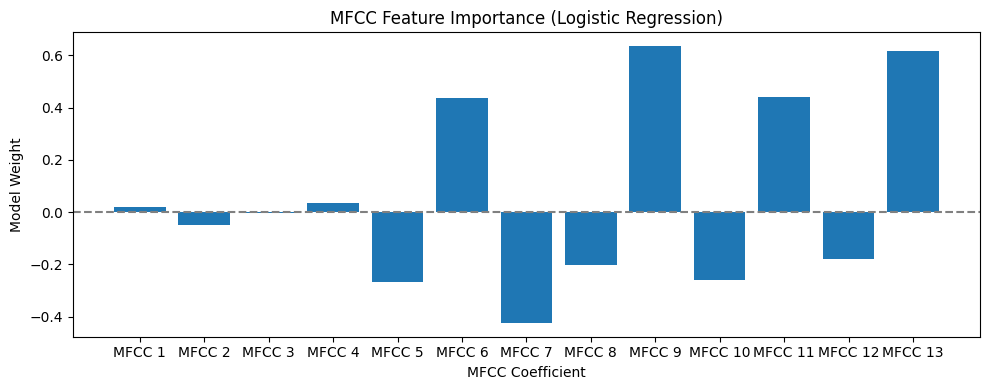

In [15]:
import matplotlib.pyplot as plt

# Get feature importance (model coefficients)
coefficients = model.coef_[0]  # shape: (13,)

# Create a bar chart
plt.figure(figsize=(10, 4))
plt.bar(range(1, 14), coefficients)
plt.xticks(range(1, 14), [f"MFCC {i}" for i in range(1, 14)])
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("MFCC Coefficient")
plt.ylabel("Model Weight")
plt.title("MFCC Feature Importance (Logistic Regression)")
plt.tight_layout()
plt.show()


## Step 5: Train a Random Forest Classifier

We train a Random Forest model using the same training and test data to compare its performance to the logistic regression baseline.


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the random forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=["no_call", "orca_call"]))


Confusion Matrix (Random Forest):
[[16  3]
 [ 2 19]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

     no_call       0.89      0.84      0.86        19
   orca_call       0.86      0.90      0.88        21

    accuracy                           0.88        40
   macro avg       0.88      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40



## Step 6: Feature Importance (Random Forest)

We visualize which MFCC features the Random Forest model uses most to classify clips as orca or non-orca.


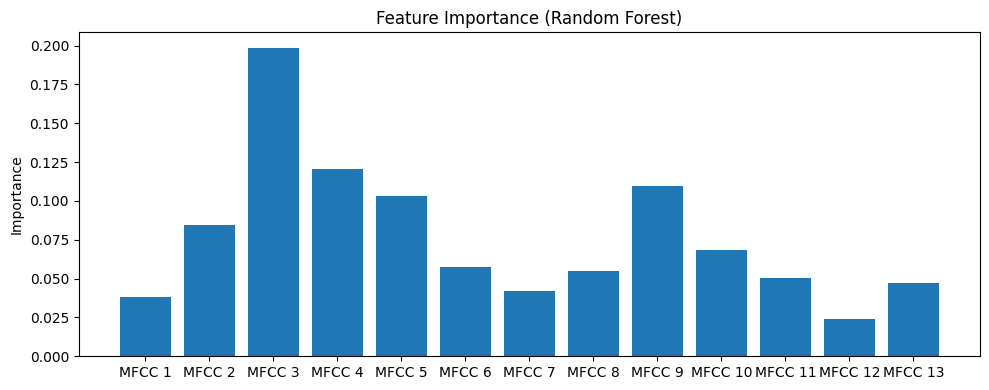

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained random forest
importances = rf_model.feature_importances_

# Feature labels
feature_names = [f"MFCC {i+1}" for i in range(13)]

# Plot
plt.figure(figsize=(10, 4))
plt.bar(range(1, 14), importances)
plt.xticks(ticks=range(1, 14), labels=feature_names)
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()
